# README

There is a lot of junk code in here, will clean up in the next commit.
You don't need to run most, if any, code from here.
The accompanying files are the important part of the commit.
The commit includes the following files:
    - [signi-quote-count-2015_1636244638891.json,
    signi-quote-count-2016_1636246832187.json,
    signi-quote-count-2017_1636249273913.json,
    signi-quote-count-2018_1636250518608.json,
    signi-quote-count-2019_1636251729971.json,
    signi-quote-count-2020_1636237785105.json] - these files contain the number of significant quotes every speaker has for each year. A quote is classified as significant if quotemaster predicts the speaker with a certainty higher than 80%.
    - signi-quote-count-combined_1636253317430.json - the combined counts of significant quotes over all of the years from 2015-2020
    - american_politicians_fixed.json - contains the wiki data for all US politicians that are or have been members of the Democratic or Republican party. Only people that were alive for at least the start of 2015 have been included.

In [1]:
import bz2
import json

In [2]:
PATH_TO_INPUT = "quotes-2020.json.bz2"
PATH_TO_OUT = "test-out-2020.json"

PATTERN_INPUT = "quotes-{}.json.bz2"

In [3]:
signi_count = 0

In [4]:
signi_quote_dict = {}

In [5]:
def iterate_through_quotes(path_to_input, path_to_out, fun_pre, fun_pre_it, fun_it, fun_post_it, fun_post):
    with bz2.open(path_to_input, 'rb') as in_file:
#         with bz2.open(PATH_TO_OUT, 'wb') as out_file:
        with open(path_to_out, 'wb') as out_file:
            fun_pre(out_file)

            i = 0
            for row in in_file:
                row = json.loads(row)
                fun_pre_it(out_file, row)
                fun_it(out_file, row)
                if fun_post_it(out_file, row, i):
                    break
                i += 1

            fun_post(out_file)

In [6]:
def iterate_through_quotes_2(path_to_input, path_to_out, fun_pre, fun_pre_it, fun_it, fun_post_it, fun_post):
    with bz2.open(path_to_input, 'rb') as in_file:
        out_file = {}
        fun_pre(out_file)

        i = 0
        for row in in_file:
            row = json.loads(row)
            fun_pre_it(out_file, row)
            fun_it(out_file, row)
            if fun_post_it(out_file, row, i):
                break
            i += 1

        fun_post(out_file)

In [7]:
def open_json(out_file):
    out_file.write('[\n'.encode('utf-8'))

In [8]:
def initialize(out_file):
    global signi_count
    global signi_quote_dict
    signi_count = 0
    signi_quote_dict = {}

In [9]:
def open_json_and_initialize(out_file):
    open_json(out_file)
    initialize(out_file)

In [10]:
def close_json(out_file):
    out_file.write('\n]'.encode('utf-8'))

In [11]:
def copy_row(out_file, row):
    copy = json.dumps(row)
    out_file.write(copy.encode('utf-8'))

In [12]:
def count_significant_quotes(out_file, row):
    global signi_count
    global signi_quote_dict
    
    probas = row['probas']
    qids = row['qids']
    
    if (len(probas) == 0 or len(qids) == 0):
        return
    
    if (probas[0][0] == 'None'):
        return
    
    p = float(probas[0][1])
    if (p < 0.8):
        return
    
    qid = qids[0]
    
    signi_count = signi_count + 1
    signi_quote_dict[qid] = signi_quote_dict.get(qid, 0) + 1

In [13]:
def close_row(out_file, row, i):
    if (i == 99):
        return True
    out_file.write(',\n'.encode('utf-8'))
    return False

In [14]:
def empty_fun(out_file, row):
    return

In [15]:
def empty_post(out_file):
    return

In [16]:
def empty_post_it(out_file, row, i):
    if (i == 999):
        return True
    return False

In [27]:
def write_dict_to_file(name, obj):
    millis = round(time.time() * 1000)
    name = f'{name}_{millis}.json'
    with open(name, 'wb') as f:
        output = json.dumps(obj)
        f.write(output.encode('utf-8'))

# Hello

In [18]:
iterate_through_quotes_2(PATH_TO_INPUT, PATH_TO_OUT, initialize, empty_fun, count_significant_quotes, empty_post_it, empty_post)

In [19]:
iterate_through_quotes(PATH_TO_INPUT, PATH_TO_OUT, open_json, empty_fun, copy_row, close_row, close_json)

# Test

In [20]:
# num_lines = sum(1 for line in bz2.open(PATH_TO_INPUT))

In [21]:
import sys
import os
import bz2
import time

year = 2019
path_to_input = PATTERN_INPUT.format(year)

MAX_LENGTH = 20

size = os.path.getsize(path_to_input)
invalid_json_count = 0
invalid_chunk_count = 0
chunk_stitching = 0
stitch_length = 0
scrap_next = False
quote_is_open = False
quote_part = ''
dat_part = 0
euro_error = False
euro_count = 0

index = 0

def proc(input):
    """Decompress and process a piece of a compressed stream"""
    dat = dec.decompress(input)
    got = len(dat)
    if got != 0:    # 0 is common -- waiting for a bzip2 block
        # process dat here
        global index
        global invalid_json_count
        global invalid_chunk_count
        global chunk_stitching
        global stitch_length
        global scrap_next
        global quote_is_open
        global quote_part
        global dat_part
        global euro_error
        global euro_count
#         if (index > 10):
#             return got
        try:
            if (euro_error):
                s = (dat_part + dat).decode('utf-8')
                euro_error = False
            else:
                s = dat.decode('utf-8')
            lines = s.split('\n')

            for line in lines:
                try:
                    if (scrap_next):
                        ob = json.loads(line)
                        scrap_next = False
                        quote_is_open = False
                        chunk_stitching -= stitch_length
                    else:
                        if (quote_is_open):
                            ob = json.loads(quote_part + line)
                            quote_is_open = False
                        else:
                            ob = json.loads(line)

                    count_significant_quotes({}, ob)
                # not a valid json string
                except ValueError:
                    if (scrap_next):
                        pass
                    else:
                        if (quote_is_open):
                            chunk_stitching += 1
                            quote_part = quote_part + line
                            stitch_length += 1

                            if (stitch_length > MAX_LENGTH):
                                invalid_json_count += 1
                                scrap_next = True
                        else:
                            quote_is_open = True
                            quote_part = line
                            stitch_length = 0
        except UnicodeDecodeError as e:
            if (euro_error):
                dat_part = dat_part + dat
            else:
                euro_error = True
                dat_part = dat
            
            euro_count += 1
        
        index += 1
    return got

# Decompress CHUNK bytes at a time.
# CHUNK = 16384
CHUNK = 1_048_576
totin = 0
totout = 0
prev = -1
dec = bz2.BZ2Decompressor()
start = time.time()

initialize({})

index = 0
with open(path_to_input, 'rb') as f:
# skip the first 35% of file
#     f.seek(round(size * 0.35))
    for chunk in iter(lambda: f.read(CHUNK), b''):
        # feed chunk to decompressor
        got = proc(chunk)

        # handle case of concatenated bz2 streams
        if dec.eof:
            rem = dec.unused_data
            dec = bz2.BZ2Decompressor()
            got += proc(rem)

        # show progress
        totin += len(chunk)
        totout += got
        if got != 0:    # only if a bzip2 block emitted
            frac = round(1000 * totin / size)
            if frac != prev:
                left = (size / totin - 1) * (time.time() - start)
                print(f'\r{frac / 10:.1f}% (~{left:.1f}s left)\tyear: {year}\tnumber of speakers: {len(signi_quote_dict)}\tstitching: {chunk_stitching}\teuro count: {euro_count}\tinvalid json count: {invalid_json_count}\tinvalid chunk count: {invalid_chunk_count}', end='')
                prev = frac

# Show the resulting size.
print(end='\r')
print(totout, 'uncompressed bytes')

write_dict_to_file(f'signi-quote-count-{year}', signi_quote_dict)

16354868483 uncompressed bytes	number of speakers: 337147	stitching: 0	euro count: 0	invalid json count: 0	invalid chunk count: 00


In [22]:
signi_quotes_file_names = [
    "signi-quote-count-2015_1636244638891.json",
    "signi-quote-count-2016_1636246832187.json",
    "signi-quote-count-2017_1636249273913.json",
    "signi-quote-count-2018_1636250518608.json",
    "signi-quote-count-2019_1636251729971.json",
    "signi-quote-count-2020_1636237785105.json"
]

In [25]:
combined_signi_dict = {}

for file_name in signi_quotes_file_names:
    with open(file_name, 'r') as f:
        one_dict = json.load(f)
        for k in one_dict.keys():
            combined_signi_dict[k] = combined_signi_dict.get(k, 0) + one_dict[k]

In [31]:
sorted_combined_signi_dict = {k: v for k, v in sorted(combined_signi_dict.items(), key=lambda item: item[1], reverse=True)}

In [33]:
write_dict_to_file('signi-quote-count-combined', sorted_combined_signi_dict)

In [ ]:
write_dict_to_file(f'signi-quote-count-{year}')

In [ ]:
print(num_lines)

In [ ]:
print(signi_count)

In [ ]:
print(len(signi_quote_dict))

(0.0, 5000.0)

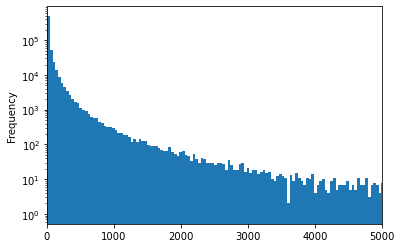

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open('signi-quote-count-combined_1636253317430.json', 'r') as f:
    dic = json.load(f)
    
    arr = np.ndarray((len(dic), 1))
    index = 0
    for k, v in dic.items():
        arr[index] = v
        index += 1
    
#     print(arr.shape)
    
df = pd.DataFrame(arr)
df[0].plot(kind="hist", logy=True, bins=5000)
plt.xlim((0, 5000))
# df[0].plot(kind="hist", loglog=True, bins=np.logspace(np.log10(1), np.log10(10e4), 100))

In [32]:
i = 0
for k, v in sorted_combined_signi_dict.items():
    print(f'{k}: {v}')
    
    i += 1
    if (i == 10):
        break

Q22686: 201293
Q1058: 76404
Q76: 59650
Q450675: 37218
Q83106: 33025
Q79983: 32394
Q43723: 28732
Q457786: 28269
Q6294: 28126
Q359442: 27652


In [ ]:
print(signi_quote_dict)

In [ ]:
SELECT DISTINCT ?item ?itemLabel 
          ?genderLabel ?citizenshipLabel ?languageLabel ?religionLabel ?ethnicLabel ?degreeLabel
          ?dateOfBirth ?placeOfBirthLabel 
#           ?nativeNameLabel ?birthNameLabel ?givenNameLabel ?familyNameLabel ?pseudonymLabel 
#           ?fatherLabel ?motherLabel ?siblingLabel ?spouseLabel ?childLabel ?numOfChild 
#           ?occupationLabel ?positionLabel ?ideologyLabel ?educatedAtLabel
          ?memberOfParty ?memberOfPartyLabel 
WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    ?item p:P106 ?statement0.
    ?statement0 (ps:P106) wd:Q82955.
    {
      ?item p:P102 ?statement1.
      ?statement1 (ps:P102) wd:Q29552.
    }
    UNION
    {
      ?item p:P102 ?statement2.
      ?statement2 (ps:P102) wd:Q29468.
    }
    MINUS {
      ?item p:P570 ?statement_3.
      ?statement_3 psv:P570 ?statementValue_3.
      ?statementValue_3 wikibase:timePrecision ?precision_3.
      FILTER(?precision_3 >= 11 )
      ?statementValue_3 wikibase:timeValue ?P570_3.
      FILTER(?P570_3 < "+2015-01-01T00:00:00Z"^^xsd:dateTime)
    }
    OPTIONAL { ?item wdt:P21 ?gender. }
    OPTIONAL { ?item wdt:P27 ?citizenship. }
    OPTIONAL { ?item wdt:P103 ?language. }
    OPTIONAL { ?item wdt:P140 ?religion. }
    OPTIONAL { ?item wdt:P172 ?ethnic. }
    OPTIONAL { ?item wdt:P512 ?degree. }
    
    OPTIONAL { ?item wdt:P569 ?dateOfBirth. }
    OPTIONAL { ?item wdt:P19 ?placeOfBirth. }
    
#     OPTIONAL { ?item wdt:P1559 ?nativeName. }
#     OPTIONAL { ?item wdt:P1477 ?birthName. }
#     OPTIONAL { ?item wdt:P735 ?givenName. }
#     OPTIONAL { ?item wdt:P734 ?familyName. }
#     OPTIONAL { ?item wdt:P742 ?pseudonym. }
    
#     OPTIONAL { ?item wdt:P22 ?father. }
#     OPTIONAL { ?item wdt:P25 ?mother. }
#     OPTIONAL { ?item wdt:P3373 ?sibling. }
#     OPTIONAL { ?item wdt:P26 ?spouse. }
#     OPTIONAL { ?item wdt:P40 ?child. }
#     OPTIONAL { ?item wdt:P1971 ?numOfChild. }
    
#     OPTIONAL { ?item wdt:P106 ?occupation. }
#     OPTIONAL { ?item wdt:P39 ?position. }
#     OPTIONAL { ?item wdt:P1142 ?ideology. }
#     OPTIONAL { ?item wdt:P69 ?educatedAt. }
    
    OPTIONAL { ?item wdt:P102 ?memberOfParty. }
  }
}

In [119]:
with open("american_politicians_fixed.json", "r") as f:
    ampoli = json.load(f)

df = pd.DataFrame(ampoli)
df.head()

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,languageLabel
0,http://www.wikidata.org/entity/Q150851,Colin Powell,male,United States of America,Episcopal Church,African Americans,Master of Business Administration,1937-04-05T00:00:00Z,New York City,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
1,http://www.wikidata.org/entity/Q112534,Ed Zschau,male,United States of America,NaN,NaN,NaN,1940-01-06T00:00:00Z,Omaha,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
2,http://www.wikidata.org/entity/Q132071,David Scott,male,United States of America,Baptists,African Americans,NaN,1945-06-27T00:00:00Z,Aynor,http://www.wikidata.org/entity/Q29552,Democratic Party,NaN
3,http://www.wikidata.org/entity/Q145627,John Gavin,male,United States of America,NaN,NaN,NaN,1931-04-08T00:00:00Z,Los Angeles,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
4,http://www.wikidata.org/entity/Q149475,Sharon Sayles Belton,female,United States of America,NaN,African Americans,NaN,1951-05-13T00:00:00Z,Saint Paul,http://www.wikidata.org/entity/Q1937395,Minnesota Democraticâ€“Farmerâ€“Labor Party,NaN


In [120]:
df.query('itemLabel == "Arnold Schwarzenegger"')
# df["item"].duplicated().sum()

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,languageLabel
21901,http://www.wikidata.org/entity/Q2685,Arnold Schwarzenegger,male,United States of America,Catholicism,Austrians,NaN,1947-07-30T00:00:00Z,Thal,http://www.wikidata.org/entity/Q29468,Republican Party,Bavarian
21905,http://www.wikidata.org/entity/Q2685,Arnold Schwarzenegger,male,United States of America,Catholicism,Austrians,NaN,1947-07-30T00:00:00Z,Thal,http://www.wikidata.org/entity/Q29468,Republican Party,German
21919,http://www.wikidata.org/entity/Q2685,Arnold Schwarzenegger,male,Austria,Catholicism,Austrians,NaN,1947-07-30T00:00:00Z,Thal,http://www.wikidata.org/entity/Q29468,Republican Party,Bavarian
21928,http://www.wikidata.org/entity/Q2685,Arnold Schwarzenegger,male,Austria,Catholicism,Austrians,NaN,1947-07-30T00:00:00Z,Thal,http://www.wikidata.org/entity/Q29468,Republican Party,German


In [100]:
def combine(x):
    d = set()
    for v in x:
        if v not in d:
            d.add(v)
    if (len(d) == 1):
        return d[0]
    arr = []
    for v in d:
        arr.append(v)
    return arr

In [101]:
df2 = df.groupby('item').agg(combine)

ValueError: Shape of passed values is (12, 22367), indices imply (11, 22367)

In [98]:
df2.query('item == "http://www.wikidata.org/entity/Q2685"')

,itemLabel,genderLabel,citizenshipLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,languageLabel
item,,,,,,,,,,,
http://www.wikidata.org/entity/Q2685,"[Arnold Schwarzenegger, Arnold Schwarzenegger,...","[male, male, male, male]","[United States of America, United States of Am...","[Catholicism, Catholicism, Catholicism, Cathol...","[Austrians, Austrians, Austrians, Austrians]","[nan, nan, nan, nan]","[1947-07-30T00:00:00Z, 1947-07-30T00:00:00Z, 1...","[Thal, Thal, Thal, Thal]","[http://www.wikidata.org/entity/Q29468, http:/...","[Republican Party, Republican Party, Republica...","[Bavarian, German, Bavarian, German]"


In [124]:
ampoli2 = dict()

index = 0
for row in ampoli:
    item = row['item']
    if item in ampoli2:
        tmp = ampoli2[item]
        columns = ['itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'ethnicLabel', 'degreeLabel', 'dateOfBirth', 'placeOfBirthLabel', 'memberOfParty', 'memberOfPartyLabel', 'languageLabel']
        for col in columns:
            if row.get(col, None) is None:
                continue
                
            t = tmp.get(col, None)
#             print(f'{t} {row[col]}')
            
            if t is None:
                t = row[col]
            elif isinstance(t, list):
                if row[col] not in t:
                    t.append(row[col])
            elif row[col] != t:
                t = [t, row[col]]
                
            tmp[col] = t
#             print(t)
    else:
        ampoli2[item] = row
        
#     index += 1
#     if (index == 10):
#         break

In [125]:
df3 = pd.DataFrame(ampoli2.values())

In [126]:
# df3.head()
df3.query('item == "http://www.wikidata.org/entity/Q2685"')

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,languageLabel
20334,http://www.wikidata.org/entity/Q2685,Arnold Schwarzenegger,male,"[United States of America, Austria]",Catholicism,Austrians,NaN,1947-07-30T00:00:00Z,Thal,http://www.wikidata.org/entity/Q29468,Republican Party,"[Bavarian, German]"


In [128]:
with open('american_politicians_final.json', 'w') as f:
    f.write(json.dumps(list(ampoli2.values())))

In [239]:
final_poli = {}
with open('american_politicians_final.json', 'r') as f:
    final_poli = json.load(f)

In [242]:
final_poli[0:5]

[{'item': 'http://www.wikidata.org/entity/Q150851',
  'itemLabel': 'Colin Powell',
  'genderLabel': 'male',
  'citizenshipLabel': 'United States of America',
  'religionLabel': 'Episcopal Church',
  'ethnicLabel': 'African Americans',
  'degreeLabel': ['Master of Business Administration', 'Bachelor of Science'],
  'dateOfBirth': '1937-04-05T00:00:00Z',
  'placeOfBirthLabel': 'New York City',
  'memberOfParty': 'http://www.wikidata.org/entity/Q29468',
  'memberOfPartyLabel': 'Republican Party'},
 {'item': 'http://www.wikidata.org/entity/Q112534',
  'itemLabel': 'Ed Zschau',
  'genderLabel': 'male',
  'citizenshipLabel': 'United States of America',
  'dateOfBirth': '1940-01-06T00:00:00Z',
  'placeOfBirthLabel': 'Omaha',
  'memberOfParty': 'http://www.wikidata.org/entity/Q29468',
  'memberOfPartyLabel': 'Republican Party'},
 {'item': 'http://www.wikidata.org/entity/Q132071',
  'itemLabel': 'David Scott',
  'genderLabel': 'male',
  'citizenshipLabel': 'United States of America',
  'religio

In [257]:
final_poli_dict = dict()
for v in final_poli:
    qid_start = v['item'].rindex('/') + 1
    key = v['item'][qid_start:]
    
    clone = dict(v)
    clone['item'] = key
#     clone.pop('item', None)
    
    final_poli_dict[key] = clone

In [259]:
index = 0
for k, v in final_poli_dict.items():
    print(f'{k}: {v}')
    index += 1
    if index == 5:
        break

Q150851: {'item': 'Q150851', 'itemLabel': 'Colin Powell', 'genderLabel': 'male', 'citizenshipLabel': 'United States of America', 'religionLabel': 'Episcopal Church', 'ethnicLabel': 'African Americans', 'degreeLabel': ['Master of Business Administration', 'Bachelor of Science'], 'dateOfBirth': '1937-04-05T00:00:00Z', 'placeOfBirthLabel': 'New York City', 'memberOfParty': 'http://www.wikidata.org/entity/Q29468', 'memberOfPartyLabel': 'Republican Party'}
Q112534: {'item': 'Q112534', 'itemLabel': 'Ed Zschau', 'genderLabel': 'male', 'citizenshipLabel': 'United States of America', 'dateOfBirth': '1940-01-06T00:00:00Z', 'placeOfBirthLabel': 'Omaha', 'memberOfParty': 'http://www.wikidata.org/entity/Q29468', 'memberOfPartyLabel': 'Republican Party'}
Q132071: {'item': 'Q132071', 'itemLabel': 'David Scott', 'genderLabel': 'male', 'citizenshipLabel': 'United States of America', 'religionLabel': 'Baptists', 'ethnicLabel': 'African Americans', 'dateOfBirth': '1945-06-27T00:00:00Z', 'placeOfBirthLabe

In [130]:
final_df = pd.DataFrame(final_poli)

In [155]:
final_df.head(10)
# bernie = final_df.query('item == "http://www.wikidata.org/entity/Q359442"')
# for v in bernie['memberOfPartyLabel']:
#     print(v)
    
# final_df.query('item == "http://www.wikidata.org/entity/Q359442"')

,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,languageLabel
0,http://www.wikidata.org/entity/Q150851,Colin Powell,male,United States of America,Episcopal Church,African Americans,"[Master of Business Administration, Bachelor o...",1937-04-05T00:00:00Z,New York City,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
1,http://www.wikidata.org/entity/Q112534,Ed Zschau,male,United States of America,NaN,NaN,NaN,1940-01-06T00:00:00Z,Omaha,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
2,http://www.wikidata.org/entity/Q132071,David Scott,male,United States of America,Baptists,African Americans,NaN,1945-06-27T00:00:00Z,Aynor,http://www.wikidata.org/entity/Q29552,Democratic Party,NaN
3,http://www.wikidata.org/entity/Q145627,John Gavin,male,United States of America,NaN,NaN,NaN,1931-04-08T00:00:00Z,Los Angeles,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
4,http://www.wikidata.org/entity/Q149475,Sharon Sayles Belton,female,United States of America,NaN,African Americans,NaN,1951-05-13T00:00:00Z,Saint Paul,"[http://www.wikidata.org/entity/Q1937395, http...","[Minnesota Democraticâ€“Farmerâ€“Labor Party, ...",NaN
5,http://www.wikidata.org/entity/Q154049,Michael Forbes,male,United States of America,Catholic Church,NaN,NaN,1952-07-16T00:00:00Z,Riverhead,"[http://www.wikidata.org/entity/Q29552, http:/...","[Democratic Party, Republican Party]",NaN
6,http://www.wikidata.org/entity/Q132302,Bill Thomas,male,United States of America,NaN,NaN,NaN,1941-12-06T00:00:00Z,Wallace,"[http://www.wikidata.org/entity/Q5020915, http...","[California Republican Party, Republican Party]",NaN
7,http://www.wikidata.org/entity/Q66107,Henry Kissinger,male,"[Germany, United States of America]",Judaism,NaN,NaN,1923-05-27T00:00:00Z,FÃ¼rth,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
8,http://www.wikidata.org/entity/Q145193,Zalmay Khalilzad,male,United States of America,Sunni Islam,NaN,NaN,1951-03-22T00:00:00Z,Mazar-i-Sharif,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
9,http://www.wikidata.org/entity/Q139389,Zach Wamp,male,United States of America,NaN,NaN,NaN,1957-10-28T00:00:00Z,Fort Benning,http://www.wikidata.org/entity/Q29468,Republican Party,NaN


In [150]:
only_keys = set()
for v in final_df['item']:
    only_keys.add(v[v.rindex('/') + 1:])

In [152]:
with open('signi-quote-count-combined_1636253317430.json', 'r') as f:
    combined_quote_count_dict = json.load(f)
    
#     arr = np.ndarray((len(dic), 1))
#     index = 0
#     for k, v in dic.items():
#         arr[index] = v
#         index += 1

In [281]:
dem_list = []
rep_list = []

CAP_TARGET = 100
DEM_PARTY = "http://www.wikidata.org/entity/Q29552"
REP_PARTY = "http://www.wikidata.org/entity/Q29468"

for v in combined_quote_count_dict:
#     row = final_df.query(f'item == "http://www.wikidata.org/entity/{v}"')
    row = final_poli_dict.get(v, None)
    
    # Could not find person in the politician dictionary
    if row is None:
        continue
    
    memberOfParty = row.get('memberOfParty', None)
    if memberOfParty is None:
        continue
    
    # Cast to one element list if not already a list
    if isinstance(memberOfParty, list) == False:
        memberOfParty = [memberOfParty]
    
    # Check membership
    if DEM_PARTY in memberOfParty:
        if REP_PARTY in memberOfParty:
            # member of both parties, don't know how to handle
#             print(row)
            continue

        if len(dem_list) < CAP_TARGET:
            dem_list.append(row)
    elif REP_PARTY in memberOfParty:
        if len(rep_list) < CAP_TARGET:
            rep_list.append(row)
    
    if len(dem_list) == CAP_TARGET and len(rep_list) == CAP_TARGET:
        break

In [282]:
print(dem_list[0:5])

[{'item': 'Q76', 'itemLabel': 'Barack Obama', 'genderLabel': 'male', 'citizenshipLabel': 'United States of America', 'languageLabel': 'English', 'religionLabel': ['Congregationalist polity', 'United Church of Christ', 'Protestantism', 'congregational church'], 'ethnicLabel': 'African Americans', 'degreeLabel': ['Bachelor of Arts', 'Juris Doctor'], 'dateOfBirth': '1961-08-04T00:00:00Z', 'placeOfBirthLabel': 'Kapiolani Medical Center for Women and Children', 'memberOfParty': 'http://www.wikidata.org/entity/Q29552', 'memberOfPartyLabel': 'Democratic Party'}, {'item': 'Q6294', 'itemLabel': 'Hillary Clinton', 'genderLabel': 'female', 'citizenshipLabel': 'United States of America', 'languageLabel': 'English', 'religionLabel': 'Methodism', 'degreeLabel': ['Juris Doctor', "bachelor's degree"], 'dateOfBirth': '1947-10-26T00:00:00Z', 'placeOfBirthLabel': 'Edgewater Hospital', 'memberOfParty': 'http://www.wikidata.org/entity/Q29552', 'memberOfPartyLabel': 'Democratic Party'}, {'item': 'Q359442', 

In [283]:
for index in range(CAP_TARGET):
    dem = dem_list[index]
    rep = rep_list[index]
#     demv = list(dem['itemLabel'].values())[0]
#     repv = list(rep['itemLabel'].values())[0]
    demv = dem['itemLabel']
    repv = rep['itemLabel']
    print(f"{index + 1:3} {demv:30} {repv:30}")
    index += 1
    
    if index % 10 == 0:
        print()

  1 Barack Obama                   Donald Trump                  
  2 Hillary Clinton                Mike Pompeo                   
  3 Bernie Sanders                 Lindsey Graham                
  4 Nancy Pelosi                   Mike Pence                    
  5 Andrew Cuomo                   Mitch McConnell               
  6 Chuck Schumer                  Marco Rubio                   
  7 Joe Biden                      Ted Cruz                      
  8 Bill de Blasio                 John McCain                   
  9 Elizabeth Warren               Jeff Sessions                 
 10 John Kerry                     Nikki Haley                   

 11 Adam Schiff                    Rand Paul                     
 12 Pete Buttigieg                 Chris Christie                
 13 Chris Murphy                   Rex Tillerson                 
 14 Richard Blumenthal             Rick Scott                    
 15 Kamala Harris                  Sean Spicer                   
 16 Cory 

In [284]:
obj = {"dem": dem_list, "rep": rep_list}
with open('top100_politicians_by_party.json', 'w') as f:
    f.write(json.dumps(obj))

In [285]:
with open('top100_politicians_by_party.json', 'r') as f:
    data = json.load(f)

test_dem_df = pd.DataFrame(data["dem"])
test_rep_df = pd.DataFrame(data["rep"])

# test_dem_df.head()

In [286]:
test_dem_df.head()

,item,itemLabel,genderLabel,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel
0,Q76,Barack Obama,male,United States of America,English,"[Congregationalist polity, United Church of Ch...",African Americans,"[Bachelor of Arts, Juris Doctor]",1961-08-04T00:00:00Z,Kapiolani Medical Center for Women and Children,http://www.wikidata.org/entity/Q29552,Democratic Party
1,Q6294,Hillary Clinton,female,United States of America,English,Methodism,NaN,"[Juris Doctor, bachelor's degree]",1947-10-26T00:00:00Z,Edgewater Hospital,http://www.wikidata.org/entity/Q29552,Democratic Party
2,Q359442,Bernie Sanders,male,United States of America,English,Judaism,Jewish people,Bachelor of Arts,1941-09-08T00:00:00Z,Brooklyn,"[http://www.wikidata.org/entity/Q327591, http:...","[independent politician, Liberty Union Party, ..."
3,Q170581,Nancy Pelosi,female,United States of America,English,Catholicism,Italian American,NaN,1940-03-26T00:00:00Z,Baltimore,http://www.wikidata.org/entity/Q29552,Democratic Party
4,Q11673,Andrew Cuomo,male,United States of America,English,Catholicism,Italian American,Juris Doctor,1957-12-06T00:00:00Z,Queens,http://www.wikidata.org/entity/Q29552,Democratic Party


In [287]:
test_rep_df.head()

,item,itemLabel,genderLabel,citizenshipLabel,languageLabel,religionLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,ethnicLabel
0,Q22686,Donald Trump,male,United States of America,English,Presbyterianism,Bachelor of Science,1946-06-14T00:00:00Z,Jamaica Hospital,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
1,Q473239,Mike Pompeo,male,United States of America,English,Presbyterianism,NaN,1963-12-30T00:00:00Z,Orange,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
2,Q22212,Lindsey Graham,male,United States of America,English,Southern Baptist Convention,"[Juris Doctor, Bachelor of Arts]",1955-07-09T00:00:00Z,Central,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
3,Q24313,Mike Pence,male,United States of America,English,Evangelical,NaN,1959-06-07T00:00:00Z,Columbus,http://www.wikidata.org/entity/Q29468,Republican Party,NaN
4,Q355522,Mitch McConnell,male,United States of America,English,Southern Baptist Convention,NaN,1942-02-20T00:00:00Z,Tuscumbia,http://www.wikidata.org/entity/Q29468,Republican Party,NaN


In [ ]:
i = 0

with bz2.open(PATH_TO_INPUT, 'rb') as in_file:
#     with bz2.open(PATH_TO_OUT, 'wb') as out_file:
    with open(PATH_TO_OUT, 'wb') as out_file:
        out_file.write('[\n'.encode('utf-8'))
        for row in in_file:
            row = json.loads(row)
#             print(row)
            
            out_row = json.dumps(row)
#             out_row = '{"hello": "world"}'
            out_row = out_row + (',\n' if i < 9 else '\n')
            out_file.write(out_row.encode('utf-8'))
            
            i+=1
            if (i == 10):
                out_file.write(']'.encode('utf-8'))
                break